## What is S-LCA?

The Spiking Locally Competitive Algorithm (S-LCA) solves the sparse coding problem:

$$\min_{a \geq 0} \frac{1}{2}||y - \Phi a||^2 + \lambda||a||_1$$

where:
- $y$ is the input signal
- $\Phi$ is the dictionary matrix (columns are basis vectors)
- $a$ is the sparse coefficient vector we want to find
- $\lambda$ controls sparsity (larger = more sparse)

S-LCA implements this using a network of spiking neurons with lateral inhibition.

The paper that inspired this Fugu implementation is the following:

[1] P. T. P. Tang, T.-H. Lin, and M. Davies, “Sparse coding by spiking neural networks: Convergence theory and computational results,” arXiv preprint arXiv:1705.05475, May 2017

## Setup



Import the required libraries and create a reproducible 3×3 dictionary matrix. We'll draw the entries from a uniform distribution every time the notebook runs so the example stays fresh while remaining deterministic via a fixed random seed.

In [ ]:
import numpy as np
import pandas as pd
from fugu import Scaffold
from fugu.bricks import LCABrick
from fugu.backends import slca_Backend

# Define a simple 3-neuron sparse coding problem
# Randomize the 3x3 dictionary 
rng = np.random.default_rng()
Phi = rng.uniform(0,0.99, size=(3, 3))

#### For repeating results from [1] ####
# Phi = np.array([
#     [0.3313, 0.8148, 0.4364],
#     [0.8835, 0.3621, 0.2182],
#     [0.3313, 0.4527, 0.8729],
# ], dtype=float)

# Input signal y (3-dimensional)
y = np.array([0.5, 1.0, 1.5], dtype=float)

# Sparsity parameter lambda
lam = 0.1

print("Dictionary Phi (randomized):")
print(np.round(Phi, 4))
print("\nInput signal y:", y)
print("Sparsity parameter λ:", lam)

Dictionary Phi (randomized):
[[0.5809 0.6898 0.4   ]
 [0.6649 0.4266 0.9873]
 [0.9846 0.0384 0.9791]]

Input signal y: [0.5 1.  1.5]
Sparsity parameter λ: 0.1


## Compute Ground Truth Sparse Code

Use a simple FISTA-based solver for the nonnegative CLASSO objective so we know the target coefficients that the S-LCA backend should recover for this randomized dictionary.

In [43]:
def normalize_columns(A: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(A, axis=0, keepdims=True) + 1e-12
    return A / norms

def classo_fista_nonneg(Phi, s, lam, max_iter=5000, tol=1e-9):
    """FISTA solver for nonnegative CLASSO: min ||s - Phi a||^2/2 + lam||a||_1"""
    Phi = normalize_columns(Phi)
    PhiT = Phi.T
    PhiTPhi = PhiT @ Phi
    PhiTs = PhiT @ s
    L = np.linalg.eigvalsh(PhiTPhi).max() + 1e-12
    tstep = 1.0 / L

    def prox_nonneg_l1(x, threshold):
        return np.maximum(0.0, x - threshold)

    N = Phi.shape[1]
    a = np.zeros(N)
    y_iter = a.copy()
    theta = 1.0

    for _ in range(max_iter):
        grad = PhiTPhi @ y_iter - PhiTs
        a_next = prox_nonneg_l1(y_iter - tstep * grad, lam * tstep)
        theta_next = 0.5 * (1 + np.sqrt(1 + 4 * theta * theta))
        y_iter = a_next + (theta - 1) / theta_next * (a_next - a)
        if np.linalg.norm(a_next - a) < tol * (np.linalg.norm(a) + 1e-12):
            a = a_next
            break
        a, theta = a_next, theta_next

    return a

a_ground_truth = classo_fista_nonneg(Phi, y, lam)
print("Ground truth CLASSO solution (a*):")
print(np.round(a_ground_truth, 6))

Ground truth CLASSO solution (a*):
[0.937678 0.       0.827691]


## Build the Neural Circuit

Create a Scaffold and add the LCA brick. The brick will automatically construct the neural circuit with the correct feedforward and lateral inhibition connections.

LCABrick is comprised of GeneralNeuron instances as oppose to the traditional LIFNeuron instances. The GeneralNeuron comes with added functionality that is not present in the original LIFNeuron. One of theses features is support for dendritic compartments.

Dendritic compartments are implemented in an Observer pattern implementing the ``Dendrite`` interface in ``compartments.py``. Dendritic compartments can accomodate a wide range of custom features. The design pattern used allows for compartment updates to be automatically updated by GeneralNeuron regardless of implementation. There is a registry of compartments that must be updated with new compartments as they are added.

The dendritic compartment used for this algorithm is called ``RecurrentInhibition``. This compartment is responsible for accumulating all the incoming spike history for a given neuron and dynamically adding an exponential decay envelope with respect to time.

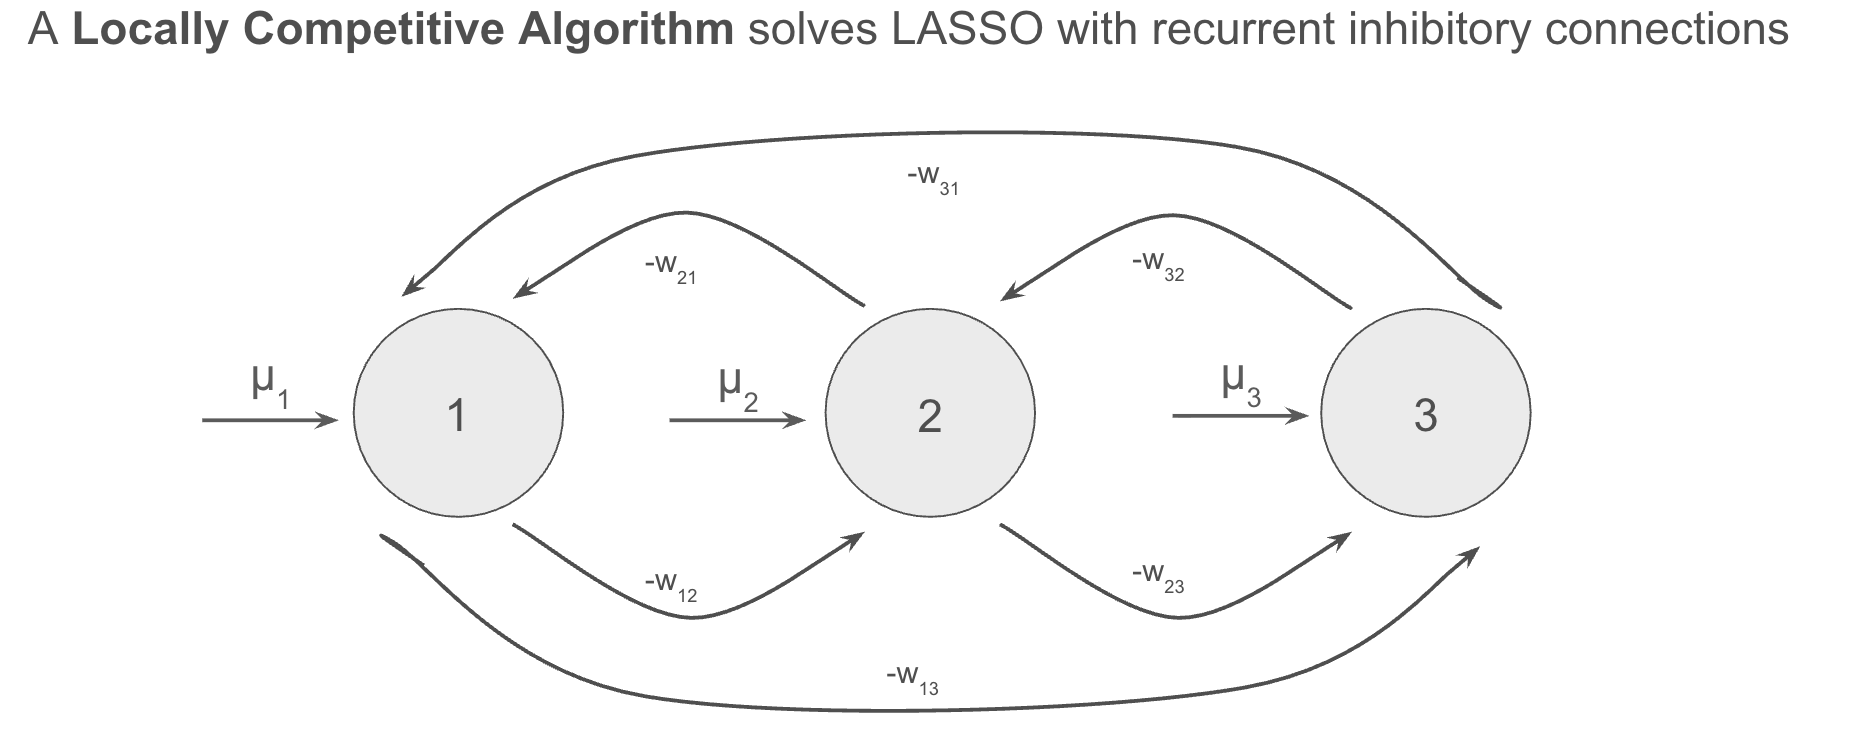

In [44]:
# Create a scaffold (container for neural circuits)
scaffold = Scaffold()

# Add the LCA brick with our problem parameters
scaffold.add_brick(
    LCABrick(Phi=Phi, input_signal=y, dt=1e-3, lam=lam),
    output=True
)

# Construct the actual neural graph
scaffold.lay_bricks()

## Compile to S-LCA Backend

Compile the scaffold to the S-LCA backend, which implements the specialized dynamics for sparse coding.

In [45]:
# Create and compile the S-LCA backend
backend = slca_Backend()
backend.compile(
    scaffold=scaffold,
    compile_args={
        'y': y,              # Input signal
        'Phi': Phi,          # Dictionary
        'lam': lam,          # Sparsity parameter
        'T_steps': 1000000,   # Total simulation steps (1000 seconds)
        't0_steps': 1000,    # Warmup period (1 second)
    }
)

print("Backend compiled successfully!")
print(f"Feedforward biases b: {backend.b}")
print(f"Inhibition matrix W shape: {backend.W.shape}")

<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
Backend compiled successfully!
Feedforward biases b: [1.83914268 1.02112476 1.83565763]
Inhibition matrix W shape: (3, 3)


## Run the Simulation

Execute the spiking neural network simulation. The network will integrate input currents, spike when thresholds are exceeded, and settle to a solution that represents the sparse coefficients.

In [46]:
# Run the simulation
dt = 1e-3
results = backend.run(rescale=True, dt=dt)

print("Simulation complete!")
print(f"Total simulation time: {backend.T_steps * dt:.1f} seconds")

Simulation complete!
Total simulation time: 1000.0 seconds


## Analyze Results

The S-LCA backend computes sparse coefficients from the tail-window average of soma currents, applying the soft-threshold operator $T_\lambda(u) = \max(0, u - \lambda)$.

In [47]:
# Extract key results
a_sparse = results['a_tail']      # Sparse coefficients
x_hat = results['x_hat']          # Reconstructed signal
spike_counts = results['counts']  # Total spikes per neuron
spike_rates = results['a_rate']   # Spike rates (Hz)

# Compute reconstruction error
reconstruction_error = np.linalg.norm(x_hat - y)
relative_error = reconstruction_error / np.linalg.norm(y)

# Identify active coefficients
active_neurons = np.where(a_sparse > 0.01)[0]
sparsity = len(active_neurons) / len(a_sparse)

print(f"Sparse coefficients a: {a_sparse}")
print(f"Active neurons: {active_neurons}")
print(f"Sparsity: {sparsity:.2%} ({len(active_neurons)}/{len(a_sparse)} active)")
print(f"\nReconstruction error: {reconstruction_error:.6f}")
print(f"Relative error: {relative_error:.6%}")

Sparse coefficients a: [0.9359658  0.         0.82980206]
Active neurons: [0 2]
Sparsity: 66.67% (2/3 active)

Reconstruction error: 0.281962
Relative error: 15.071514%


## Ground Truth Comparison

Compare the S-LCA results with the expected solution from a standard optimization solver (FISTA for CLASSO).

In [48]:
# Compare solutions against the analytically computed CLASSO optimum
solution_error = np.linalg.norm(a_sparse - a_ground_truth)
max_difference = np.max(np.abs(a_sparse - a_ground_truth))

print("Ground Truth vs S-LCA:")
print(f"  Ground truth a*: {np.round(a_ground_truth, 6)}")
print(f"  S-LCA result:    {np.round(a_sparse, 6)}")
print(f"\nSolution error ||a - a*||: {solution_error:.6f}")
print(f"Max coefficient difference: {max_difference:.6f}")
print(f"\nMatch: {np.allclose(a_sparse, a_ground_truth, atol=0.01)}")

Ground Truth vs S-LCA:
  Ground truth a*: [0.937678 0.       0.827691]
  S-LCA result:    [0.935966 0.       0.829802]

Solution error ||a - a*||: 0.002718
Max coefficient difference: 0.002111

Match: True


## Summary Table

Display all results in a nice summary table for easy comparison.

In [49]:
# Create a comprehensive results DataFrame
results_df = pd.DataFrame({
    'Neuron': [f'Neuron {i+1}' for i in range(len(a_sparse))],
    'Ground Truth a*': a_ground_truth,
    'S-LCA a': np.round(a_sparse, 3),
    'Difference': np.round(np.abs(a_sparse - a_ground_truth), 4),
    'Spike Count': spike_counts.astype(int),
    'Spike Rate (Hz)': np.round(spike_rates, 2),
})

print("="*80)
print("S-LCA RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Summary metrics
summary_df = pd.DataFrame({
    'Metric': [
        'Input signal y',
        'Reconstructed x̂',
        'Reconstruction error',
        'Relative error',
        'Solution error ||a - a*||',
        'Active coefficients',
        'Sparsity',
        'Simulation time',
    ],
    'Value': [
        str(np.round(y, 3)),
        str(np.round(x_hat, 3)),
        f"{reconstruction_error:.6f}",
        f"{relative_error:.6%}",
        f"{solution_error:.6f}",
        f"{len(active_neurons)}/{len(a_sparse)}",
        f"{sparsity:.2%}",
        f"{backend.T_steps * dt:.1f}s",
    ]
})

print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

if np.allclose(a_sparse, a_ground_truth, atol=0.01):
    print("\nSUCCESS: S-LCA solution approximates ground truth")

S-LCA RESULTS SUMMARY
  Neuron  Ground Truth a*  S-LCA a  Difference  Spike Count  Spike Rate (Hz)
Neuron 1         0.937678    0.936      0.0017          935             0.94
Neuron 2         0.000000    0.000      0.0000            0             0.00
Neuron 3         0.827691    0.830      0.0021          830             0.83

PERFORMANCE METRICS
                   Metric               Value
           Input signal y       [0.5 1.  1.5]
         Reconstructed x̂ [0.641 1.037 1.258]
     Reconstruction error            0.281962
           Relative error          15.071514%
Solution error ||a - a*||            0.002718
      Active coefficients                 2/3
                 Sparsity              66.67%
          Simulation time             1000.0s

SUCCESS: S-LCA solution approximates ground truth
